In [142]:
import os
import sys
import pickle
from tqdm import tqdm
import itertools
import dateparser
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# Add repo
git_dir = os.path.abspath('../')

# Define data path
data_path = os.path.join(git_dir, 'data', 'pm-transcripts')

# Define data output path
data_output_path = os.path.join(git_dir, 'data', 'pm-transcripts-processed')

In [278]:
coarse_emotions = ['positive', 'negative', 'ambiguous', 'neutral']

positive_emotions = ['admiration', 
                     'amusement',
                     'approval',
                     'caring',
                     'desire',
                     'excitement',
                     'gratitude',
                     'joy',
                     'love',
                     'optimism',
                     'pride',
                     'relief']

negative_emotions = ['anger',
                     'annoyance',
                     'disappointment',
                     'disapproval',
                     'disgust',
                     'embarrassment',
                     'fear',
                     'grief',
                     'nervousness',
                     'remorse',
                     'sadness']

ambiguous_emotions = ['confusion',
                      'curiosity',
                      'realization',
                      'surprise']

neutral_emotions = ['neutral']

all_emotions = list(itertools.chain.from_iterable([positive_emotions, negative_emotions, ambiguous_emotions, neutral_emotions]))

emotion_mapper = {}
for emotion in all_emotions:
    if emotion in positive_emotions:
        emotion_mapper[emotion] = coarse_emotions[0]#'coarspositive'
        
    elif emotion in negative_emotions:
        emotion_mapper[emotion] = coarse_emotions[1]#'negative'
        
    elif emotion in ambiguous_emotions:
        emotion_mapper[emotion] = coarse_emotions[2]#'ambiguous'
        
    elif emotion in neutral_emotions:
        emotion_mapper[emotion] = coarse_emotions[3]#'neutral'
    
    else:
        raise ValueError(emotion)

In [314]:
def get_corpus_by_pm(target_pm=''):
    
    # Enumerate and load all pickles
    corpus = []
    for file in tqdm(os.listdir(data_output_path)):
        if file.endswith(".pkl"):
            with open(os.path.join(data_output_path, file), 'rb') as f:
                data = pickle.load(f)

            simple_data = {k:data[k] for k in ['pm', 'date', 'emotions']}
            if simple_data['pm'] == target_pm:
                corpus.append(simple_data)
    return corpus

In [315]:
corpus = get_corpus_by_pm('Howard, John')

100%|██████████| 8911/8911 [00:01<00:00, 8237.12it/s] 


In [316]:
def count_emotions(sentence_emotion_list):
    '''
    Count the number of times each emotion is expressed in a sentence
    Count the total number of sentence
    Count the total number of emotions expressed
    '''
    
    emotion_counter_fine = {k: 0 for k in all_emotions}
    emotion_counter_coarse = {k: 0 for k in coarse_emotions}
    emotion_counter_nonneutral = 0
    emotion_counter_all = 0
    
    for sentence in sentence_emotion_list:
        for i, label in enumerate(sentence['labels']):
            emotion_counter_fine[label] += 1
            emotion_counter_coarse[emotion_mapper[label]] += 1
            emotion_counter_all += 1
            
            if label not in neutral_emotions:
                emotion_counter_nonneutral += 1
            
            
    return emotion_counter_fine, emotion_counter_coarse, emotion_counter_all, emotion_counter_nonneutral
        

In [317]:
# Update documents
for i, document in enumerate(tqdm(corpus)):
    emotion_counter_fine, emotion_counter_coarse, emotion_counter_all, emotion_counter_nonneutral = count_emotions(document['emotions'])
    document['emotion_counter_fine'] = emotion_counter_fine
    document['emotion_counter_coarse'] = emotion_counter_coarse
    document['emotion_counter_all'] = emotion_counter_all
    document['emotion_counter_nonneutral'] = emotion_counter_nonneutral
    document['datetime'] = datetime.datetime.strptime(document['date'], '%d/%m/%Y')

100%|██████████| 5865/5865 [00:00<00:00, 29751.73it/s]


In [318]:
def get_emotion_dataframe(corpus):
    # Get ordered datetimes and 
    dates = []
    emotion_counter_all = []
    emotion_counter_nonneutral = []
    
    emotions_coarse = {k: [] for k in coarse_emotions}
    emotions_fine = {k: [] for k in all_emotions}
    
    for document in tqdm(corpus):
        dates.append(document['datetime'])
        emotion_counter_all.append(document['emotion_counter_all'])
        emotion_counter_nonneutral.append(document['emotion_counter_nonneutral'])
        
        for emotion in coarse_emotions:
            emotions_coarse[emotion].append(document['emotion_counter_coarse'][emotion])
        for emotion in all_emotions:
            emotions_fine[emotion].append(document['emotion_counter_fine'][emotion])
    
    counts = {'date': dates,
              'emotion_counter_all': emotion_counter_all,
              'emotion_counter_nonneutral': emotion_counter_nonneutral}
    
    df_dict = {}
    df_dict.update(counts)
    df_dict.update(emotions_coarse)
    df_dict.update(emotions_fine)
    
    df = pd.DataFrame.from_dict(df_dict).sort_values(by='date').set_index('date')
    
    return df

In [319]:
df = get_emotion_dataframe(corpus)

100%|██████████| 5865/5865 [00:00<00:00, 122535.39it/s]


In [320]:
def get_coarse_proportional_emotion_df(df_in):
    # We exclude 'neutral'
    df = df_in[coarse_emotions[0:-1]].copy()
    for column in df.columns:
        df[column] = df[column]/df_in['emotion_counter_nonneutral']
        
    df.columns = [column+'_normed' for column in df.columns]
    df = df.fillna(0)
        
    return df
    

In [321]:
df_coarse = get_coarse_proportional_emotion_df(df)

In [322]:
def plot_coarse_emotion_proportions(df_coarse, window='120d', title='PM Speech Sentiment Proportion'):
    plot_colors = sns.color_palette("hls", 8)
    plot_colors = [plot_colors[2], plot_colors[0], plot_colors[1]]
    
    legend_labels = ['Positive', 'Negative', 'Ambiguous']
    
    SMALL_SIZE = 15
    MEDIUM_SIZE = 18
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE) 
    
    
    
    # Take rolling average over window
    df = df_coarse.rolling(window).mean().copy()
    
    # Renormalise
    df_norm = df.sum(axis=1)
    for column in df.columns:
        df[column] = df[column]/df_norm
    df = df.fillna(0)
    
    line_list = []
    for i, column in enumerate(df_coarse.columns):
        if i==0:
            line_list.append(df_coarse[column])
        else:
            line_list.append(df_coarse[column]+line_list[-1])
            
    #plt.plot(df.cumsum(axis=1))
    # Take cumulative sum
    df_cumsum = df.cumsum(axis=1) # column names are unchanged
    
    
    # Plot filled regions
    fig=plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')
    
    for i, col in enumerate(df_cumsum.columns):
        if i==0:
            plt.fill_between(df_cumsum.index, 0*df_cumsum[col], df_cumsum[col], color=plot_colors[i], alpha=0.5)
        else:
            plt.fill_between(df_cumsum.index, df_cumsum[prev_col], df_cumsum[col], color=plot_colors[i], alpha=0.5)
        prev_col = col
        
    for i, col in enumerate(df_cumsum.columns):
        plt.plot(df_cumsum.index, df_cumsum[col], color=plot_colors[i], lw=2)
    
    plt.grid()
    plt.axis('tight')
    plt.autoscale(enable=True, axis='both', tight=True)
    plt.legend(legend_labels)
    plt.xlabel('Date',  fontweight='bold')
    plt.ylabel('Proportion',  fontweight='bold')
    plt.title(title,  fontweight='bold' )

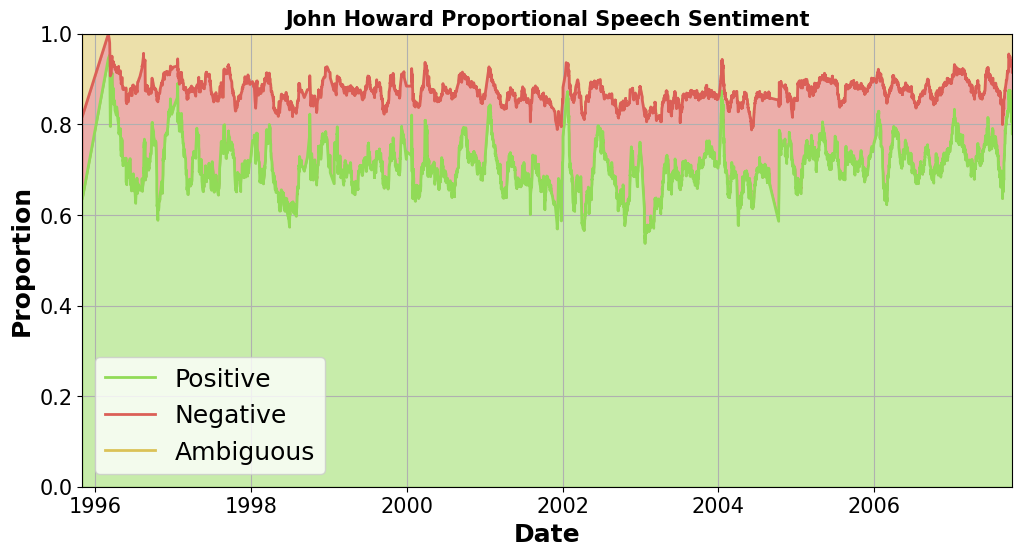

In [323]:
plot_coarse_emotion_proportions(df_coarse, window='30d', title='John Howard Proportional Speech Sentiment')

### Repeat for Gillard, Julia

100%|██████████| 2072/2072 [00:00<00:00, 300473.60it/s]


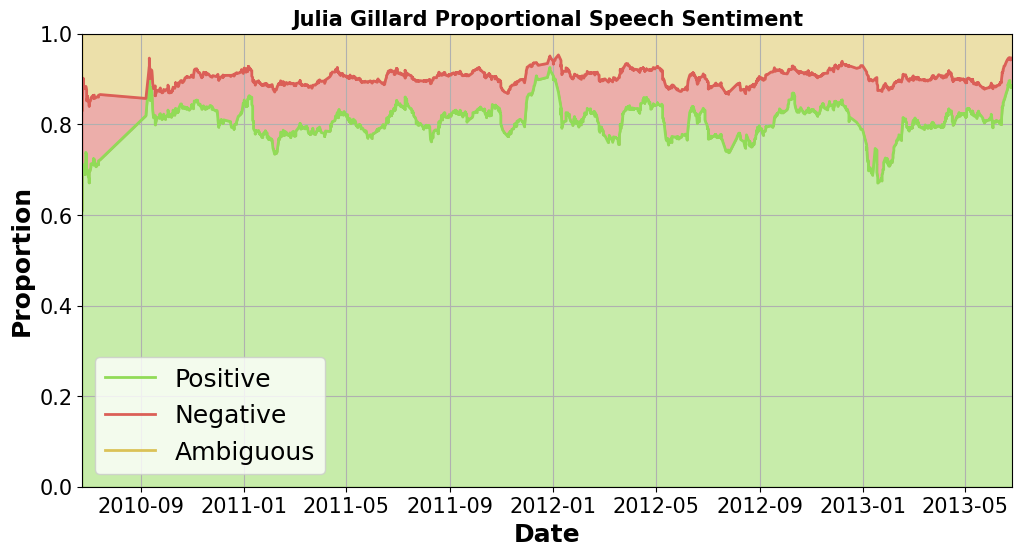

In [313]:
# Get corpus
corpus = get_corpus_by_pm('Gillard, Julia')

# Update documents
for i, document in enumerate(tqdm(corpus)):
    emotion_counter_fine, emotion_counter_coarse, emotion_counter_all, emotion_counter_nonneutral = count_emotions(document['emotions'])
    document['emotion_counter_fine'] = emotion_counter_fine
    document['emotion_counter_coarse'] = emotion_counter_coarse
    document['emotion_counter_all'] = emotion_counter_all
    document['emotion_counter_nonneutral'] = emotion_counter_nonneutral
    document['datetime'] = datetime.datetime.strptime(document['date'], '%d/%m/%Y')
    
# Convert to df
df = get_emotion_dataframe(corpus)

# Get only coarse emotions
df_coarse = get_coarse_proportional_emotion_df(df)

# Plot
plot_coarse_emotion_proportions(df_coarse, window='30d', title='Julia Gillard Proportional Speech Sentiment')